# Hotel Ratings Summary Tool

## CS 410 Fall 2018 (Text Information Systems)

- Tyler Watkins
- 16-Dec-2018

The tools does the following:

- Summarize rating
- Make wordcloud with wordcloud
- Do sentiment analysis with NLTK
- Do topic modelling with gensim (LDA)


### Load Libraries and Data

In [34]:
# Load Libraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gensim
from gensim import corpora
import re
import pyLDAvis.gensim

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
data = pd.read_csv('cleaned_reviews.csv')

### Hotel Review Summary Functions

In [36]:
def full_hotel_review(hotel_name):
    print(hotel_name)
    hotel = data[data.name == hotel_name]
    rating_reviews(hotel)
    plt.figure
    generate_wordcloud(hotel)
    plt.figure
    get_sentiment(hotel)
    get_topics(hotel)

In [37]:
def rating_reviews(hotel):
    n_reviews = hotel.reviewsrating.count()
    avg_rating = hotel.reviewsrating.mean()
    msg = "\nThis hotel has been reviewed %i times with an average rating of %.2f out of 5. \n" % (n_reviews,avg_rating)
    print(msg)

In [38]:
def generate_wordcloud(hotel):
    
    # Add all text from selected hotel
    text = " ".join(review for review in hotel.cleanrev)
    
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["hotel", "room", "stay", "place", "one", "de", "que", "la", "en","el", "con"])

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", contour_width=3, contour_color='firebrick').generate(text)

    # Display the generated image:
    print("These are the words that hotel guests frequently use when reviewing this hotel:")
    plt.figure(figsize=[12,6])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [39]:
def get_sentiment(hotel):
    
    # Make review text into a single doc
    doc_complete = list(hotel.cleanrev)
    
    # Using NLTK built in function (could train a Naive Bayes Classifier)
    import nltk
    def nltk_sentiment(sentence):
        from nltk.sentiment.vader import SentimentIntensityAnalyzer

        nltk_sentiment = SentimentIntensityAnalyzer()
        score = nltk_sentiment.polarity_scores(sentence)
        return score

    nltk_results = [nltk_sentiment(row) for row in doc_complete]
    results_df = pd.DataFrame(nltk_results)
    text_df = pd.DataFrame(doc_complete, columns = ['text'])
    nltk_df = text_df.join(results_df)

    # Melt the dataframe to get boxplots
    df = nltk_df.melt(id_vars=['text', 'compound'], var_name='Sentiments', value_name='Percentages')
    
    # Make plot
    f, ax = plt.subplots(figsize=(9, 5))
    sns.boxplot(data=df, x = 'Sentiments', y='Percentages')
    plt.title('Sentiment Analysis of Reviews', fontsize=15)
    plt.ylabel('Percentages', fontsize=15)
    plt.xlabel(' ')
    plt.xticks(np.arange(3), labels = ['Negative', 'Neutral', 'Positive'], fontsize=15)

    print("\nThis is the analyzed sentiment of guests reviewing this hotel:")

    # Show the figure
    plt.show()

In [43]:
def get_topics(hotel):
    
    # Make review text into a single doc
    doc_complete = list(hotel.cleanrev)
    
    # Clean by removing the punctuations, stopwords and normalize the corpus.
    from nltk.corpus import stopwords 
    from nltk.stem.wordnet import WordNetLemmatizer
    import string
    
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    def clean(doc):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized

    doc_clean = [clean(doc).split() for doc in doc_complete]
    
    import gensim
    from gensim import corpora

    # Create the term dictionary of our corpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(doc_clean)

    # Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    
    # Create the object for LDA model using gensim library
    Lda = gensim.models.ldamodel.LdaModel

    # Run and Train LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
    
    # Extract the 3 main topics (10 words each) from the LDA model and display them
    x = ldamodel.show_topics(num_topics=3, num_words=10)
    import re
    topic1 = " ".join(re.findall("[a-zA-Z]+", x[0][1]))
    topic2 = " ".join(re.findall("[a-zA-Z]+", x[1][1]))
    topic3 = " ".join(re.findall("[a-zA-Z]+", x[2][1]))

    print("The words associated with the 3 most important topics of reviews for this hotel are: \n")
    print("Topic 1 top words: %s"%(topic1))
    print("Topic 2 top words: %s"%(topic2))
    print("Topic 3 top words: %s"%(topic3))
    print("\n")

    
    # Display LDA viz with pyLDAvis library
    import pyLDAvis.gensim
    lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
    pyLDAvis.enable_notebook(lda_display)

### Use the Hotels Rating Summary Tool here:

Fiesta Inn and Suites

This hotel has been reviewed 546 times with an average rating of 1.45 out of 5. 

These are the words that hotel guests frequently use when reviewing this hotel:


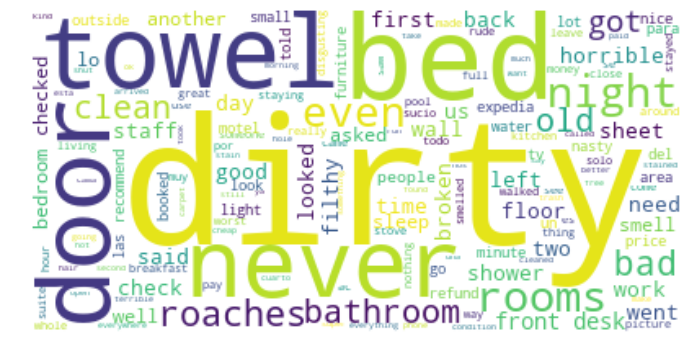


This is the analyzed sentiment of guests reviewing this hotel:


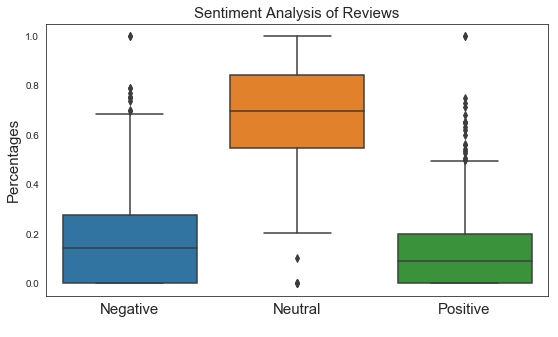

The words associated with the 3 most important topics of reviews for this hotel are: 

Topic 1 top words: la de que en el hotel muy para e con
Topic 2 top words: hotel room place bed night would roach stay never u
Topic 3 top words: room hotel stay dirty towel bed one door would like


Best Western of Long Beach

This hotel has been reviewed 317 times with an average rating of 3.66 out of 5. 

These are the words that hotel guests frequently use when reviewing this hotel:


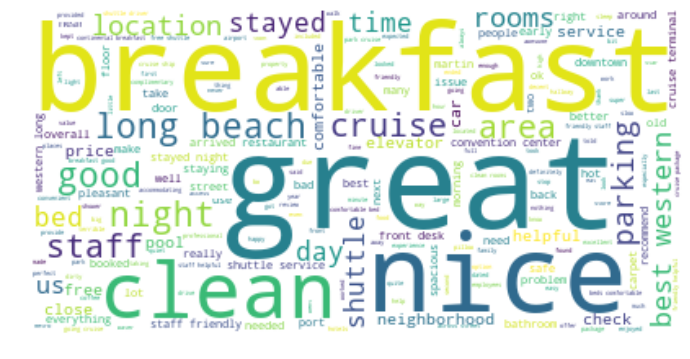


This is the analyzed sentiment of guests reviewing this hotel:


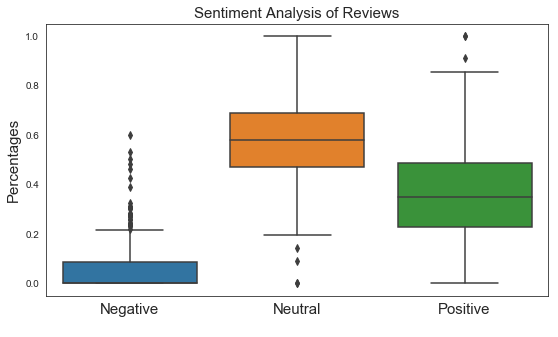

The words associated with the 3 most important topics of reviews for this hotel are: 

Topic 1 top words: hotel room great good breakfast area staff nice parking would
Topic 2 top words: room cruise hotel clean breakfast stay beach long nice shuttle
Topic 3 top words: hotel location staff would breakfast u night time one


Comfort Inn

This hotel has been reviewed 189 times with an average rating of 4.07 out of 5. 

These are the words that hotel guests frequently use when reviewing this hotel:


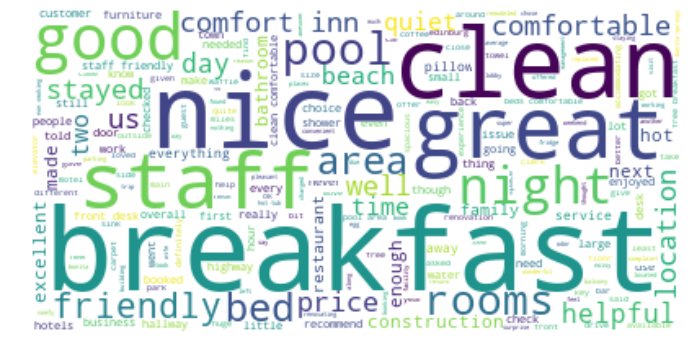


This is the analyzed sentiment of guests reviewing this hotel:


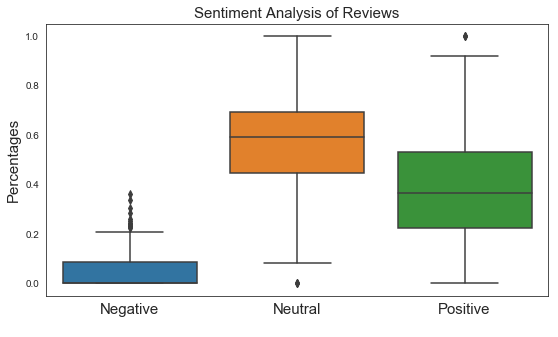

The words associated with the 3 most important topics of reviews for this hotel are: 

Topic 1 top words: room hotel breakfast great night good staff stay nice one
Topic 2 top words: hotel room stay clean would staff bed stayed one breakfast
Topic 3 top words: room clean breakfast nice pool staff hotel stay friendly comfortable


Ip Casino Resort Spa

This hotel has been reviewed 392 times with an average rating of 4.05 out of 5. 

These are the words that hotel guests frequently use when reviewing this hotel:


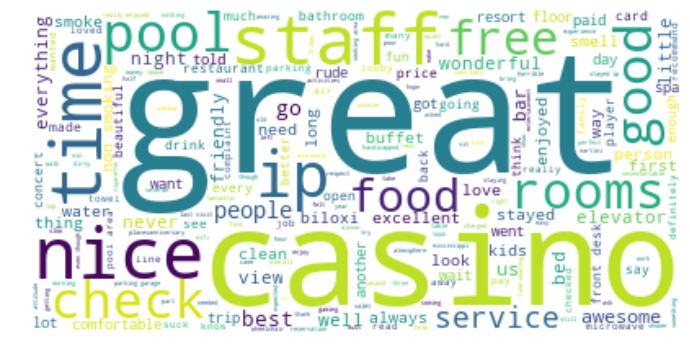


This is the analyzed sentiment of guests reviewing this hotel:


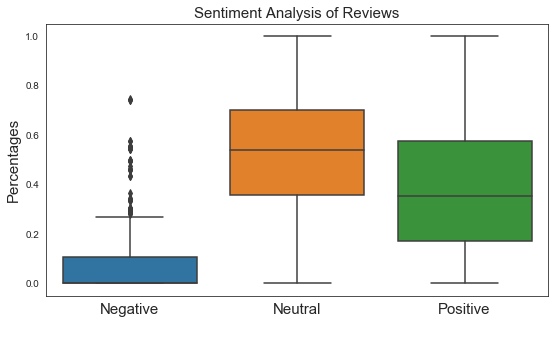

The words associated with the 3 most important topics of reviews for this hotel are: 

Topic 1 top words: room great hotel stay casino nice staff good ip pool
Topic 2 top words: room non smoking casino pool stay check time free u
Topic 3 top words: great service bar place person best buffet ip love people


Hotel Valencia Santana Row

This hotel has been reviewed 197 times with an average rating of 4.32 out of 5. 

These are the words that hotel guests frequently use when reviewing this hotel:


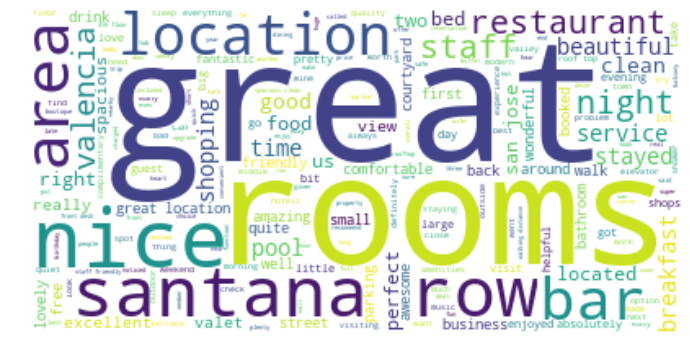


This is the analyzed sentiment of guests reviewing this hotel:


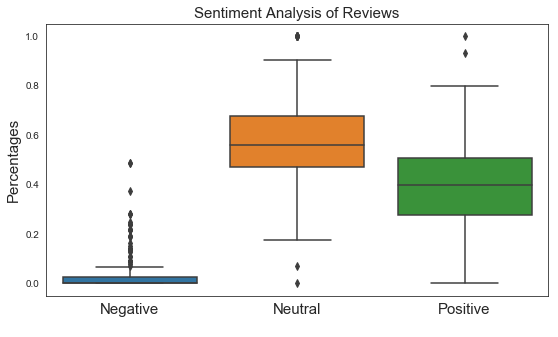

The words associated with the 3 most important topics of reviews for this hotel are: 

Topic 1 top words: hotel room great bar row santana nice valencia location stay
Topic 2 top words: room hotel great nice breakfast stay row area santana location
Topic 3 top words: room hotel great row service santana night staff location nice


Hampton Inn Virginia Beach Oceanfront North

This hotel has been reviewed 225 times with an average rating of 4.39 out of 5. 

These are the words that hotel guests frequently use when reviewing this hotel:


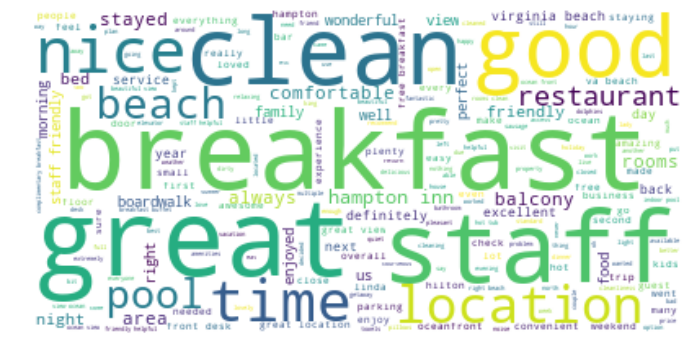


This is the analyzed sentiment of guests reviewing this hotel:


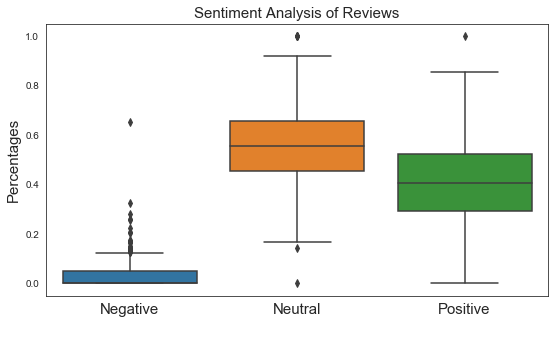

The words associated with the 3 most important topics of reviews for this hotel are: 

Topic 1 top words: staff great room hotel breakfast location good nice clean beach
Topic 2 top words: room hotel stay breakfast great beach clean staff would view
Topic 3 top words: room hotel breakfast time staff morning great stayed desk good




In [44]:
# Test hotels to choose from
hotels_test = ["Fiesta Inn and Suites", 
               "Best Western of Long Beach",
               "Comfort Inn", "Ip Casino Resort Spa", 
               "Hotel Valencia Santana Row", 
               "Hampton Inn Virginia Beach Oceanfront North"]


# Enter a hotel name here and click enter
hotel_name = "Comfort Inn"

#for hotel in hotels_test:
#    full_hotel_review(hotel)